# Project: Exploring how different factors might affect whether patient shows up for their appointment or not.

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this progect I'll be analyzing data that collects information from 100k medical appointments in Brazil. 
   
Each row includes a number of characteristics about the patient, among them:

- `ScheduledDay` tells on what day the patient set up their appointment.

- `Neighborhood` indicates the location of the hospital.

- `Scholarship` indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.

In [1]:
# set up import statements for all the packages for future use

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Questions I'd like to answer during my exploration:
- What gender and age group has higher tendency to miss an appointment?
- Could the enrollment in Bolsa Família program be an important factor in prediction of patients attendance?
- Does having any particular condition affect patients attendance more than others?
- Does waiting time affect amount of patients who miss their appointment?

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [2]:
# load the data

df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


In [3]:
# get familiar with data types and check for missing data

df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
# check for the duplicates in the data

sum(df.duplicated())

0

There is no missing data and duplicate rows in this data set. Not all data types in columns of interest are correct (`ScheduledDay` and `AppointmentDay` need to be date object) and one column will be renamed for the ease of use.

In [5]:
# check few columns for invalid inputs

df.Age.unique()

array([ 62,  56,   8,  76,  23,  39,  21,  19,  30,  29,  22,  28,  54,
        15,  50,  40,  46,   4,  13,  65,  45,  51,  32,  12,  61,  38,
        79,  18,  63,  64,  85,  59,  55,  71,  49,  78,  31,  58,  27,
         6,   2,  11,   7,   0,   3,   1,  69,  68,  60,  67,  36,  10,
        35,  20,  26,  34,  33,  16,  42,   5,  47,  17,  41,  44,  37,
        24,  66,  77,  81,  70,  53,  75,  73,  52,  74,  43,  89,  57,
        14,   9,  48,  83,  72,  25,  80,  87,  88,  84,  82,  90,  94,
        86,  91,  98,  92,  96,  93,  95,  97, 102, 115, 100,  99,  -1])

In [6]:
df.Gender.unique()

array(['F', 'M'], dtype=object)

In [7]:
df.Scholarship.unique()

array([0, 1])

In [8]:
df.Hipertension.unique()

array([1, 0])

In [9]:
df.Diabetes.unique()

array([0, 1])

In [10]:
df.Alcoholism.unique()

array([0, 1])

In [11]:
df.Handcap.unique()

array([0, 1, 2, 3, 4])

In [12]:
df['No-show'].unique()

array(['No', 'Yes'], dtype=object)

There is 1 invalid input in Age column (-1) that need to be dropped and there are categories of handicap people (not boolean as for other conditions) in Handcap column to keep in mind.

### Fixing column name and its inputs and dealing with the wrong row

In [13]:
# rename column 'No-show' to 'show_up'

df.rename(columns={'No-show': 'show_up'}, inplace=True)
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'show_up'],
      dtype='object')

In [14]:
# fix 'Yes'/'No' inputs in 'show_up' column to get rid of the confusion 

df['show_up'].replace({'Yes': 0, 'No':1}, inplace=True)
df.show_up.unique()

array([1, 0])

Now the name of the column is `show_up` and `0` is for patients who did not show up, `1` is for those who did.

Dropping the row:

In [15]:
# check the shape of df before dropping one row

df.shape 

(110527, 14)

In [16]:
# locate the row

df.loc[df['Age'] == -1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show_up
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,1


In [17]:
# drop the row and check if droped the right row
df.drop(99832, inplace=True)
df.loc[df['Age'] == -1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show_up


In [18]:
# change datatype for SheduledDay and AppointmentDay columns from string to date object

df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110526 non-null  float64
 1   AppointmentID   110526 non-null  int64  
 2   Gender          110526 non-null  object 
 3   ScheduledDay    110526 non-null  object 
 4   AppointmentDay  110526 non-null  object 
 5   Age             110526 non-null  int64  
 6   Neighbourhood   110526 non-null  object 
 7   Scholarship     110526 non-null  int64  
 8   Hipertension    110526 non-null  int64  
 9   Diabetes        110526 non-null  int64  
 10  Alcoholism      110526 non-null  int64  
 11  Handcap         110526 non-null  int64  
 12  SMS_received    110526 non-null  int64  
 13  show_up         110526 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 12.6+ MB


In [19]:
# create a new column 'waiting_time' wich shows how many days passed from schduled day to appointment day

df['waiting_time'] = df['AppointmentDay'] - df['ScheduledDay']
df['waiting_time'] = df['waiting_time'].apply(lambda x: x.days)
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show_up,waiting_time
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0


In [20]:
# check new column for negative values

df['waiting_time'].unique()

array([  0,   2,   3,   1,   4,   9,  29,  10,  23,  11,  18,  17,  14,
        28,  24,  21,  15,  16,  22,  43,  30,  31,  42,  32,  56,  45,
        46,  39,  37,  38,  44,  50,  60,  52,  53,  65,  67,  91,  66,
        84,  78,  87, 115, 109,  63,  70,  72,  57,  58,  51,  59,  41,
        49,  73,  64,  20,  33,  34,   6,  35,  36,  12,  13,  40,  47,
         8,   5,   7,  25,  26,  48,  27,  19,  61,  55,  62, 176,  54,
        77,  69,  83,  76,  89,  81, 103,  79,  68,  75,  85, 112,  -1,
        80,  86,  98,  94, 142, 155, 162, 169, 104, 133, 125,  96,  88,
        90, 151, 126, 127, 111, 119,  74,  71,  82, 108, 110, 102, 122,
       101, 105,  92,  97,  93, 107,  95,  -6, 139, 132, 179, 117, 146,
       123])

In [21]:
# drop rows with negative values

rows_to_drop = df[df['waiting_time'] < 0]
df.drop(rows_to_drop.index, inplace=True, axis=0)
df.shape

(110521, 15)

<a id='eda'></a>
## Exploratory Data Analysis


In [22]:
# create sepate data frame without columns: 
# PatientId, AppointmentID, ScheduledDay, AppointmentDay, Neighbourhood for exploration 

new_df = df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'Neighbourhood'],axis = 1)
new_df.head(1)

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show_up,waiting_time
0,F,62,0,1,0,0,0,0,1,0


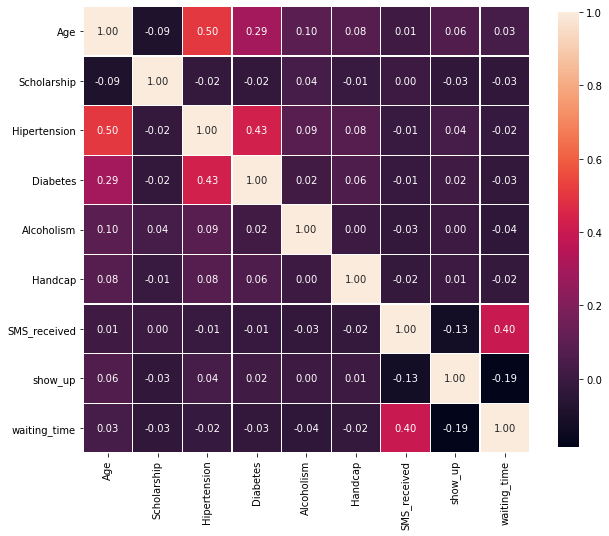

In [23]:
# create heatmap of correlations in the data frame

def correlation_heatmap(df):
    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, fmt='.2f', square=True, linewidths=.3, 
                annot=True, cbar_kws={"shrink": .80})
    plt.show();
    
correlation_heatmap(new_df)

Since the provided data are categorical there is no strong correlation might be observed. The strongest correlation here is between medical conditions which is not in the focus of this project.

### What gender and age group has higher tendency to miss an appointment?

In [24]:
# create dataframe with patients who did not show up for their appointment

noshow_df = df.copy().query('show_up == 0')
noshow_df.shape

(22314, 15)

In [25]:
# create a new column 'age_group' for the age grouping,
# where 0-14 y.o. - children, 15-24 y.o. - youth, 25-64 y.o. - working age, 65+ y.o. - elderly

group_edges = [0, 14, 24, 64, float('inf')] 
group_names = ['children', 'youth', 'working_age', 'elderly']
noshow_df['age_group'] = pd.cut(noshow_df['Age'], group_edges, labels=group_names, right=False)

noshow_df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show_up,waiting_time,age_group
6,7.336882e+14,5630279,F,2016-04-27,2016-04-29,23,GOIABEIRAS,0,0,0,0,0,0,0,2,youth


In [26]:
# get counts for each gender and age group

gender_counts = noshow_df.groupby(['Gender', 'age_group']).count().PatientId
gender_counts

Gender  age_group  
F       children       2217
        youth          2427
        working_age    8298
        elderly        1649
M       children       2392
        youth          1106
        working_age    3460
        elderly         765
Name: PatientId, dtype: int64

In [27]:
# get total counts for each gender
gender_totals = noshow_df.groupby('Gender').count().PatientId
gender_totals

Gender
F    14591
M     7723
Name: PatientId, dtype: int64

In [28]:
# get proportions by dividing female counts by total number of female patients
f_proportions = gender_counts['F'] / gender_totals['F']
f_proportions

age_group
children       0.151943
youth          0.166335
working_age    0.568707
elderly        0.113015
Name: PatientId, dtype: float64

In [29]:
# get proportions by dividing male counts by total number of male patients
m_proportions = gender_counts['M'] / gender_totals['M']
m_proportions

age_group
children       0.309724
youth          0.143209
working_age    0.448012
elderly        0.099055
Name: PatientId, dtype: float64

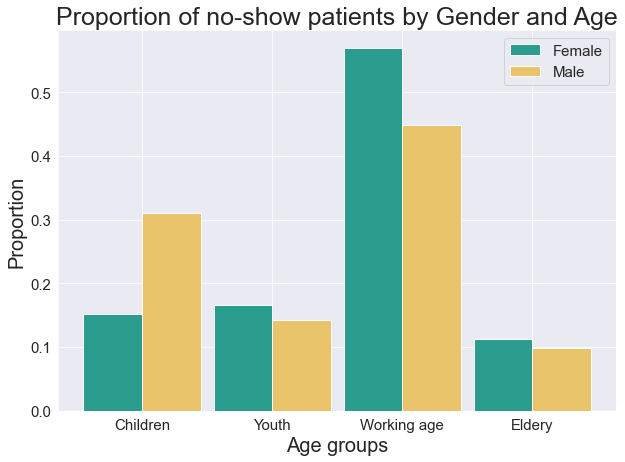

In [30]:
# plotting
plt.figure(figsize=(10, 7))
sns.set_style('darkgrid')

ind = np.arange(len(f_proportions))
width = 0.45

plt.bar(ind, f_proportions, width, color='#2A9D8F', alpha=1, label='Female')
plt.bar(ind + width, m_proportions, width, color='#E9C46A', alpha=1, label='Male')

plt.ylabel('Proportion', fontsize=20)
plt.xlabel('Age groups', fontsize=20)
plt.title('Proportion of no-show patients by Gender and Age', fontsize=25)
locations = ind + width / 2
labels = ['Children', 'Youth', 'Working age', 'Eldery']
plt.xticks(locations, labels, fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15);

People of working age represent larger group of population and tend to miss their appointments more often. Among them women don't show up more often than men. In youth and eldery age groups there is no significcant difference in gender. 
The chart shows significant difference between boys and girls regarding showing up to their appointment but there is not enought data in this data set to look into this deeper and this group also strongly dependent on their parents. 

### Could be enrollment in Bolsa Família programm be an important factor in prediction of patients attendance?

In [31]:
# create data set of people enrolled in Bolsa Família (BF) program

bf = df.copy().query('Scholarship == 1')  
bf.shape

(10861, 15)

In [32]:
# get the proportion of no-show-up patients among enrolled in BF

bf_not_showed = bf.query('show_up == 0').count().PatientId
bf_not_showed_proportion = bf_not_showed / bf.count().PatientId
bf_not_showed_proportion

0.2373630420771568

In [33]:
# create data set of people not enrolled in BF program

no_bf = df.copy().query('Scholarship == 0') 
no_bf.shape

(99660, 15)

In [34]:
# get the proportion of no-show-up patients among not enrolled in BF

nobf_not_showed = no_bf.query('show_up == 0').count().PatientId
nobf_not_showed_proportion = nobf_not_showed / no_bf.count().PatientId
nobf_not_showed_proportion

0.19803331326510135

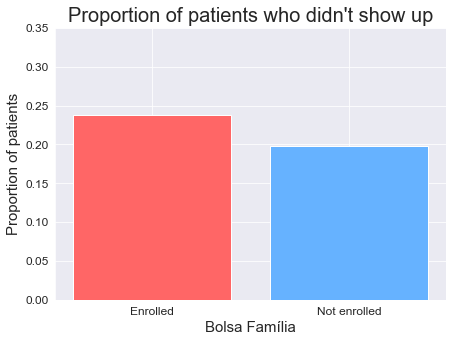

In [35]:
# create bar chart

plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
colors=['#FF6666', '#66B2FF']

plt.bar(["Enrolled", "Not enrolled"], [bf_not_showed_proportion, nobf_not_showed_proportion], color=colors) 
plt.title("Proportion of patients who didn't show up", fontsize=20)
plt.xlabel("Bolsa Família", fontsize=15)
plt.ylabel("Proportion of patients", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0, 0.35]);

From the chart above it looks like enrollment in Bolsa Família programm alone does not affect attendance of patients and it can not be used as a sole factor to predict if a patient will show up for their scheduled appointment.

### Does having any particular condition affect patients attendance more than others?

In [36]:
# write the function to get the proportion of patients with Hipertension, Diabetes, Alcoholism, Handicap 
# who did not show up for their appointment

def get_proportions(query):
    df_slice = df.copy().query(query)  
    grouped = df_slice.groupby('show_up').count().PatientId
    return grouped.loc[0] / grouped.sum()

In [37]:
# creat list with proportion for each condition
# I assumed here that 0 means no disability, 1,2,3,4 mean different levels/types of disabilities

queries = ['Hipertension == 1', 'Diabetes == 1', 'Alcoholism == 1', 'Handcap == [1,2,3,4]']
conditions = [ get_proportions(query) for query in queries ]
conditions

[0.17301958625751113,
 0.18003273322422259,
 0.20148809523809524,
 0.18088432335864224]

In [38]:
# get the list of proportions to make each bar 100%

total_prop = [ 1.0 - x for x in conditions ]
total_prop

[0.8269804137424889,
 0.8199672667757774,
 0.7985119047619047,
 0.8191156766413578]

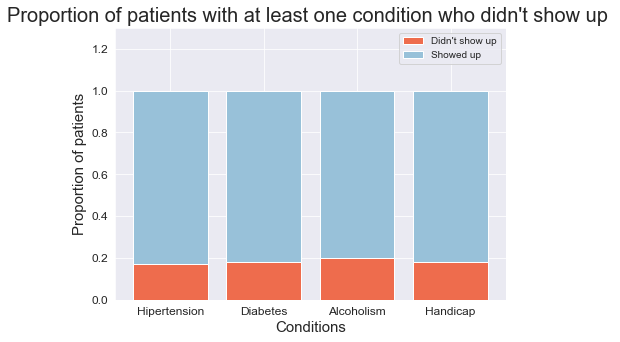

In [39]:
# plotting stacked bar chart for each condition

labels = ['Hipertension', 'Diabetes', 'Alcoholism', 'Handicap']

plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')

plt.bar(labels, conditions, color='#ee6c4d')
plt.bar(labels, total_prop, bottom = conditions, color='#98c1d9')

plt.title("Proportion of patients with at least one condition who didn't show up ", fontsize=20)
plt.xlabel("Conditions", fontsize=15)
plt.ylabel("Proportion of patients", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# add space to fit legend
plt.ylim([0, 1.3])

plt.legend(["Didn't show up", "Showed up"]);

This chart didn't take into account that some patients have more than one condition at the same time. The focus was on checking if one or more conditions stand out regarding patients attendance. It seems that none of them has more influence than others, but all together they might form a significant factor in prediction of patients attendance.

### Does waiting time affect amount of patients who miss their appointment?

In [40]:
no_show_patients = df.copy().query('show_up == 0')
grouped = no_show_patients.groupby('waiting_time').count().PatientId
grouped.head(8)

waiting_time
0    1792
1    1113
2    1602
3     644
4    1231
5     872
6    1001
7    1309
Name: PatientId, dtype: int64

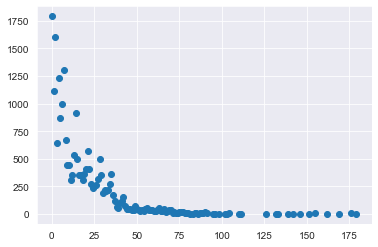

In [41]:
plt.scatter(grouped.index, grouped)
plt.show()

In [42]:
# get the proportion of no-show patients with waiting time up to 14 days to the total amount of no-show patients

prop_14_days = grouped[:15].sum() / no_show_patients.shape[0]
prop_14_days

0.5928116877296764

Almost 60% of patients who didn't show up for their appointment had less than 2 weeks waiting time and thus waiting time doesn't have strong influence over patiens attendance.

<a id='conclusions'></a>
## Conclusions

   People with chronic conditions like hipertension, diabetes, alcoholism and different types of disability show equally high tendency to miss their medical appointments. Since people of working age also have this tendency these two factors might be of use in prediction of whether patient show up or not. Limited amount of medical conditions presented in this data set and no data about household composition don't allow further exploration of these factors. 
   
   Enrollment in Bolsa Família program does not seem to affect attendance of patients despite differences between population enrolled and not.